#### Data Preprocessing

In [ ]:
# importing necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
import gensim.downloader as api
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, f1_score
from collections import Counter
import shap
import warnings

warnings.filterwarnings("ignore")
nltk.download("punkt")

# Global parameters
MAX_LEN = 50               # Max sequence length for tweets
EMBED_DIM = 300            # Word2Vec Skip-gram embedding dimension
SEED = 42                  # For reproducibility

np.random.seed(SEED)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yugah\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
# Load Dataset and Consolidate Labels

# Load dataset
df = pd.read_csv("Sentiment_Data.csv", encoding='latin1')

# Preview
print("Raw dataset shape:", df.shape)
print("Sample data:")
print(df.head())

# Consolidate sentiment labels into 3 classes
label_map = {
    'Mild_Pos': 'Positive',
    'Strong_Pos': 'Positive',
    'Mild_Neg': 'Negative',
    'Strong_Neg': 'Negative',
    'Neutral': 'Neutral'
}

# Apply mapping
df['Sentiment'] = df['Sentiment'].map(label_map)

# Drop rows with any unknown/NaN labels (just in case)
df = df.dropna(subset=['Sentiment'])

# Show updated distribution
print("\nLabel distribution after mapping:")
print(df['Sentiment'].value_counts())


Raw dataset shape: (451332, 2)
Sample data:
                                               Tweet Sentiment
0  @_angelica_toy Happy Anniversary!!!....The Day...  Mild_Pos
1  @McfarlaneGlenda Happy Anniversary!!!....The D...  Mild_Pos
2  @thevivafrei @JustinTrudeau Happy Anniversary!...  Mild_Pos
3  @NChartierET Happy Anniversary!!!....The Day t...  Mild_Pos
4  @tabithapeters05 Happy Anniversary!!!....The D...  Mild_Pos

Label distribution after mapping:
Sentiment
Positive    297704
Neutral      77016
Negative     76612
Name: count, dtype: int64


In [7]:
# Data Cleaning


# 1. Slang and abbreviation dictionary
slang_dict = {
    "u": "you",
    "ur": "your",
    "idk": "i do not know",
    "brb": "be right back",
    "btw": "by the way",
    "omg": "oh my god",
    "lmao": "laughing",
    "smh": "shaking my head",
    "wanna": "want to",
    "gonna": "going to",
    "gotta": "got to",
    "ikr": "i know right",
    "thx": "thanks",
    "np": "no problem",
    "imo": "in my opinion",
    "dm": "direct message",
    "wtf": "what the heck",
    "tbh": "to be honest"
}

# 2. Negation pattern handling
negation_patterns = [
    (r"\b(not|no|never|n't)\s+(\w+)", r"\1_\2")  # e.g., "not good" → "not_good"
]

# 3. Regex patterns dictionary
regex_patterns = {
    'URL': r'https?://\S+|www\.\S+',
    'MENTION': r'@\w+',
    'SPECIAL_CHARS': r'[^a-zA-Z\s#<>]',  # Allow hashtags, <USER>
    'NUMBERS': r'\d+',
    'EXTRA_SPACES': r'\s+'
}

# 4. Cleaning function
def clean_tweet_advanced(text):
    # Convert to string and lowercase
    text = str(text).lower()

    # Convert emojis to text
    text = emoji.demojize(text, delimiters=(" ", " "))

    # Replace slang and abbreviations
    for slang, full in slang_dict.items():
        pattern = r'\b' + re.escape(slang) + r'\b'
        text = re.sub(pattern, full, text)

    # Normalize sarcasm like "FreeDUMB" to "freedom"
    text = re.sub(r'\b(freedumb)\b', 'freedom', text)

    # Replace mentions with <USER>
    text = re.sub(regex_patterns['MENTION'], '<USER>', text)

    # Remove URLs
    text = re.sub(regex_patterns['URL'], '', text)

    # Remove numbers
    text = re.sub(regex_patterns['NUMBERS'], '', text)

    # Handle negations
    for pattern, replacement in negation_patterns:
        text = re.sub(pattern, replacement, text)

    # Remove unwanted special characters (keep hashtags, <USER>)
    text = re.sub(regex_patterns['SPECIAL_CHARS'], '', text)

    # Normalize whitespace
    text = re.sub(regex_patterns['EXTRA_SPACES'], ' ', text).strip()

    return text

# 5. Deduplicate original tweets
before = df.shape[0]
df = df.drop_duplicates(subset=["Tweet"])
after = df.shape[0]
print(f"Removed {before - after} duplicate tweets.")

# 6. Apply cleaning function to create Clean_Tweet column
df['Clean_Tweet'] = df['Tweet'].apply(clean_tweet_advanced)

# 7. Preview
print("\nSample cleaned tweets:")
print(df[['Tweet', 'Clean_Tweet']].head(5))


Removed 52 duplicate tweets.

Sample cleaned tweets:
                                               Tweet  \
0  @_angelica_toy Happy Anniversary!!!....The Day...   
1  @McfarlaneGlenda Happy Anniversary!!!....The D...   
2  @thevivafrei @JustinTrudeau Happy Anniversary!...   
3  @NChartierET Happy Anniversary!!!....The Day t...   
4  @tabithapeters05 Happy Anniversary!!!....The D...   

                                         Clean_Tweet  
0  <USER> happy anniversarythe day the freedom di...  
1  <USER> happy anniversarythe day the freedom di...  
2  <USER> <USER> happy anniversarythe day the fre...  
3  <USER> happy anniversarythe day the freedom di...  
4  <USER> happy anniversarythe day the freedom di...  


Class distribution BEFORE undersampling:
Positive: 254630 (62.37%)
Neutral: 77008 (18.86%)
Negative: 76608 (18.77%)


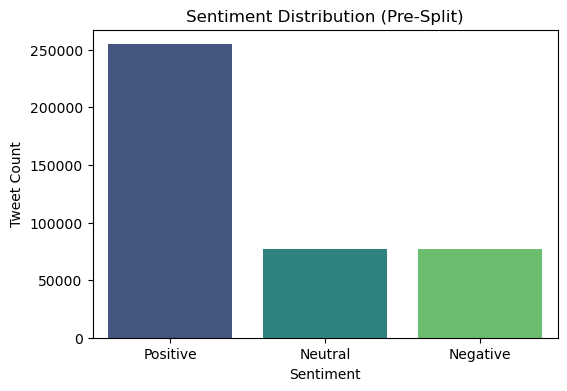


Majority class 'Positive' exceeds 60%. Applying proportional undersampling...

Class distribution AFTER proper undersampling:
Positive: 230423 (60.0%)
Neutral: 77008 (20.05%)
Negative: 76608 (19.95%)


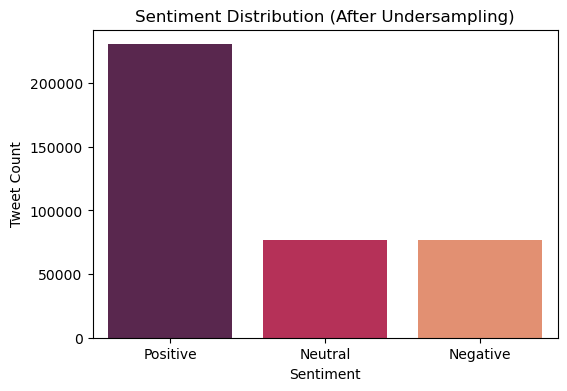

In [10]:
# Class distribution

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Calculate class stats
label_counts = df['Sentiment'].value_counts()
label_percentages = round(100 * label_counts / label_counts.sum(), 2)

print("Class distribution BEFORE undersampling:")
for label in label_counts.index:
    print(f"{label}: {label_counts[label]} ({label_percentages[label]}%)")

# Plot pre-undersampling distribution
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Sentiment Distribution (Pre-Split)")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.show()

# Step 2: Undersample if any class > 60%
total = label_counts.sum()
label_fractions = label_counts / total

major_class = label_fractions.idxmax()
if label_fractions[major_class] > 0.60:
    print(f"\nMajority class '{major_class}' exceeds 60%. Applying proportional undersampling...")

    # Target max 60% of total = 0.6 * total after undersampling
    minority_df = df[df['Sentiment'] != major_class]
    num_minority = len(minority_df)

    # Solve: majority_count + minority_count = new_total
    #        majority_count = 0.6 * new_total
    # ➜ majority_count = 0.6 * (majority_count + num_minority)
    # ➜ majority_count = (0.6 * num_minority) / 0.4
    target_majority = int((0.6 * num_minority) / 0.4)

    # Sample and combine
    majority_df = df[df['Sentiment'] == major_class].sample(n=target_majority, random_state=SEED)
    df = pd.concat([majority_df, minority_df]).sample(frac=1, random_state=SEED).reset_index(drop=True)

    # Recalculate
    label_counts = df['Sentiment'].value_counts()
    label_percentages = round(100 * label_counts / label_counts.sum(), 2)

    print("\nClass distribution AFTER proper undersampling:")
    for label in label_counts.index:
        print(f"{label}: {label_counts[label]} ({label_percentages[label]}%)")

    # Plot post-undersampling
    plt.figure(figsize=(6,4))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette="rocket")
    plt.title("Sentiment Distribution (After Undersampling)")
    plt.xlabel("Sentiment")
    plt.ylabel("Tweet Count")
    plt.show()
else:
    print("\nNo undersampling needed. Class proportions acceptable.")


In [11]:
# Stratified Train/Validation/Test Split

from sklearn.model_selection import train_test_split

# Step 1: First, split into 85% train+val and 15% test
train_val_df, test_df = train_test_split(
    df,
    test_size=0.15,
    stratify=df['Sentiment'],
    random_state=SEED
)

# Step 2: Split train_val into train (80%) and val (20%)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.20,
    stratify=train_val_df['Sentiment'],
    random_state=SEED
)

# Final sizes
print("Final dataset sizes:")
print(f"Train set:      {len(train_df)} rows")
print(f"Validation set: {len(val_df)} rows")
print(f"Test set:       {len(test_df)} rows")

# Final distribution check
print("\nClass distribution in each split:")
print("Train:\n", train_df['Sentiment'].value_counts(normalize=True).round(3))
print("Validation:\n", val_df['Sentiment'].value_counts(normalize=True).round(3))
print("Test:\n", test_df['Sentiment'].value_counts(normalize=True).round(3))


Final dataset sizes:
Train set:      261146 rows
Validation set: 65287 rows
Test set:       57606 rows

Class distribution in each split:
Train:
 Sentiment
Positive    0.600
Neutral     0.201
Negative    0.199
Name: proportion, dtype: float64
Validation:
 Sentiment
Positive    0.600
Neutral     0.201
Negative    0.199
Name: proportion, dtype: float64
Test:
 Sentiment
Positive    0.600
Neutral     0.201
Negative    0.199
Name: proportion, dtype: float64


#### Exporting the split data

In [12]:
# Save Cleaned and Split Datasets

# Save to CSV for downstream processing (e.g., embedding, modeling)
train_df.to_csv("train_cleaned.csv", index=False)
val_df.to_csv("val_cleaned.csv", index=False)
test_df.to_csv("test_cleaned.csv", index=False)

print("✅ Train, validation, and test datasets saved successfully!")
print("Files:")
print("- train_cleaned.csv")
print("- val_cleaned.csv")
print("- test_cleaned.csv")


✅ Train, validation, and test datasets saved successfully!
Files:
- train_cleaned.csv
- val_cleaned.csv
- test_cleaned.csv
